In [1]:
!nvidia-smi

Mon Aug 16 16:28:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d jangedoo/utkface-new

 96% 317M/331M [00:03<00:00, 142MB/s]
100% 331M/331M [00:03<00:00, 106MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

In [1]:
import cv2
import glob

images = []
ages = []
genders = []

images_path = glob.glob("/content/UTKFace/*")
for image_path in images_path:
  age = int( image_path.split("_")[0].split("/")[-1])
  gender = int(image_path.split("_")[1])
  ages.append(age)
  genders.append(gender)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (48, 48))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image)

In [2]:
len(images)

23708

In [3]:
labels=[]
i=0
while i<len(ages):
  label=[]
  label.append([ages[i]])
  label.append([genders[i]])
  labels.append(label)
  i+=1

In [4]:
labels[0]

[[50], [1]]

In [5]:
import numpy as np
images_f = np.array(images)
labels_f = np.array(labels)
images_f = images_f/255

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_f, labels_f, test_size=0.25, random_state=0)

In [7]:
Y_train = [y_train[:,1],y_train[:,0]]
Y_test = [y_test[:,1],y_test[:,0]]

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [9]:
input = Input((48, 48, 3))
x = Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, kernel_regularizer=l2(0.001))(input)
x = Dropout(0.1)(x)
x = Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)
x = Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)
x = Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)
flatten = Flatten()(x)
dense_1= Dense(64,activation='relu')(flatten)
dense_2= Dense(64,activation='relu')(flatten)
dense_1=Dropout(0.2)(dense_1)
dense_2=Dropout(0.2)(dense_2)
sex= Dense(1,activation="sigmoid",name='sex_out')(dense_1)
age= Dense(1,activation="relu",name='age_out')(dense_2)
model = Model(inputs=[input], outputs=[sex,age])
model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam",
	metrics=["accuracy"])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 46, 46, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 44, 44, 64)   18496       dropout[0][0]                    
______________________________________________________________________________________________

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint 
import tensorflow as tf
fle_s='Age_sex_detection.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [12]:
History=model.fit(X_train,Y_train,batch_size=64,validation_data=(X_test,Y_test),epochs=500,callbacks=[callback_list])

Epoch 1/500
278/278 [==============================] - 46s 50ms/step - loss: 14.8828 - sex_out_loss: 0.6733 - age_out_loss: 14.0720 - sex_out_accuracy: 0.6484 - age_out_accuracy: 0.0465 - val_loss: 11.6013 - val_sex_out_loss: 0.4297 - val_age_out_loss: 11.0479 - val_sex_out_accuracy: 0.8180 - val_age_out_accuracy: 0.0405

Epoch 00001: val_loss improved from inf to 11.60133, saving model to Age_sex_detection.h5
Epoch 2/500
278/278 [==============================] - 13s 46ms/step - loss: 10.6951 - sex_out_loss: 0.4180 - age_out_loss: 10.1566 - sex_out_accuracy: 0.7843 - age_out_accuracy: 0.0440 - val_loss: 9.2689 - val_sex_out_loss: 0.3274 - val_age_out_loss: 8.8220 - val_sex_out_accuracy: 0.8593 - val_age_out_accuracy: 0.0477

Epoch 00002: val_loss improved from 11.60133 to 9.26894, saving model to Age_sex_detection.h5
Epoch 3/500
278/278 [==============================] - 13s 48ms/step - loss: 9.4972 - sex_out_loss: 0.3639 - age_out_loss: 9.0141 - sex_out_accuracy: 0.8341 - age_out_acc

In [13]:
from google.colab.patches import cv2_imshow

Actual Sex: Female
Predicted Sex: Female


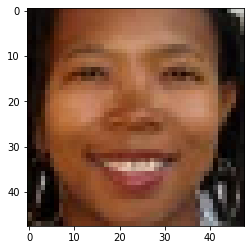

In [25]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt

image_test_path = random.choice(images_path)
test_image = cv2.imread(image_test_path)
actual_age = image_test_path.split("_")[0].split("/")[-1]
actual_gender = image_test_path.split("_")[1]
test_image = tf.keras.preprocessing.image.load_img(
    image_test_path, target_size=(48, 48)
)
plt.imshow(test_image)
img_array = tf.keras.preprocessing.image.img_to_array(test_image)
img_array = tf.expand_dims(img_array, 0) 
pred = model.predict(img_array)
sexs=['Male','Female']   
predict_age = int(np.round(pred[1][0]))   
predict_sex = int(np.round(pred[0][0]))  
print("Actual Sex: "+ sexs[int(actual_gender)])
print("Predicted Sex: "+ sexs[predict_sex])